In [75]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, 

In [2]:
#clear field
def clear(g):
    g *= 0
    L = len(g)
    for a in range(L):
        g[a,0] = 2
        g[a,L-1] = 2
        g[0,a] = 2
        g[L-1,a] = 2

In [3]:
#global variable for cherry
C = 1
#global array for the direction
d = np.array([[0,1], [-1,0], [0,-1], [1,0]])

In [4]:
#add a cherry to a random empty space
def add_cherry(g):
    zero = np.where(g==0)
    r = np.random.randint(len(zero[0]))
    g[zero[0][r]][zero[1][r]] = C

In [5]:
#add snake to the field array g=3 -> head, g=4 -> rest of the snake (only used in visualization)
def add_snake(g,snake):
    kigyo = 3
    for s in snake:
        g[s[0],s[1]] = kigyo
        kigyo = 4

In [6]:
#return what is ahead
def check_head(g, snake, ir):
    head = np.array(snake[0])
    head += d[ir]
    return g[head[0]][head[1]]

In [7]:
#mode snake, if it had eaten a cherry then make it longer
def move_snake(g, snake, ir, cherry):
    head = np.array(snake[0])
    g[head[0],head[1]] = 4
    head += d[ir]
    g[head[0],head[1]] = 3
    snake.insert(0,list(head))
    if not cherry:
        tail = snake.pop()
        g[tail[0],tail[1]] = 0

In [8]:
#generate the input for th NN based on the current position. it returns an array of length 8
def get_input(g,snake):
    cherry = np.where(g == C)
    c = np.array([cherry[0][0],cherry[1][0]])
    data = np.zeros(8,dtype=int)
    #first four is wether we can go in that direction
    for i in range(4):
        data[i] = check_head(g,snake,i) < 2
    #next four if the cherry is in that direction
    head = np.array(snake[0])
    for i in range(4):
        data[4 + i] = np.dot(d[i],c - head) > 0
    return(data)

In [9]:
#feedforward which is just a multiplication, since we have only a single layer
def get_output(W,X):
    return 1.0 / (1.0 + np.exp(np.dot(X,W)))

In [10]:
#given the weights makes a full run of the snake up to muxstep number of steps. Saves the game in the list save
#Algorithm
# 1. check what is ahead
#   - wall or snake -> die -> score -= 5 and return
#   - cherry add +10 to score
# 2. move snake and go to 1.
def full_run(L,W,maxstep,save):
    L2 = int(L/2)
    snake = [[L2,L2],[L2,L2+1],[L2+1,L2+1]]
    g = np.zeros((L,L), dtype=int)
    clear(g)
    add_snake(g,snake)
    add_cherry(g)
    score = 0
    save.append(np.copy(g))
    for i in range(maxstep):
        nd = get_output(W,get_input(g,snake)).argmax()
        ahead = check_head(g, snake, nd)
        cherry = 0
        if ahead == C:
            score += 10
            cherry = 1
        elif ahead >= 2:
            score -= 5
            return score + min(10, int(i / 5))
        move_snake(g,snake,nd,cherry)
        if cherry:
            add_cherry(g)
        save.append(np.copy(g))
    return(score + min(10, int(i / 5)))

In [11]:
#This does not work in function. Can anyone tell me why???
def anim_snake(save):
    fig = plt.figure()
    ims = []
    for s in save:
        im = plt.imshow(s, animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)
    plt.show()
    return ims

In [12]:
snake = [[10,10],[10,11],[11,11]]
g = np.zeros((20,20),dtype=int)
clear(g)
add_snake(g,snake)
add_cherry(g)
W = np.random.normal(0,1.0,(8,4))

In [13]:
#switch off animation to continue
plt.imshow(g);

<IPython.core.display.Javascript object>

In [14]:
W = np.random.normal(0,1.0,(8,4))
save = []
score = full_run(20,W,1000, save)
print(score, len(save))

-4 10


In [15]:
#animate snake (since function does not work)
fig = plt.figure()
ims = []
for s in save:
    im = plt.imshow(s, animated=True)
    ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)
#plt.show()

<IPython.core.display.Javascript object>

In [16]:
rc('animation', html='jshtml')
ani

### TASK: Teach computer to play snake using genetic algorithm

1. Create a population fo 100 genes (each must have a (8,4) matrix for weights, zero mean and e.g. variance 1), if your computer is slow do it with 50 genes
2. Make a loop for generations (~50-70 is generally enough, you may want to start with less)
3. Make a full run with all 100 genes and save the scores (and the gameplay) in arrays/lists
4. Identify the best performing gene (and save its gameplay to an other list)
5. Identify the 50 best performing genes
6. Perform crossover
  * get two random genes from the best performing 50
  * recombine randomly their genes
  * replace one of the 50 worst performing gene with this recombination
7. With a small (e.g. 0.0001~0.001) probability modify randomly the value of the weights of the genes
8. Plot the score of the best performing gene versus generation
9. Animate the best gene of the last generation

Hint: <code>np.random.choice(2, size=10, p=[0.1,0.9])</code> generates an array of 10 numbers of 0 with probability 0.1 and 1 with probability 0.9

In [43]:
def best_performing_genes(scores, N):
  indexes = np.argsort(scores)[-N:]
  return sorted(indexes)

In [140]:
def crossover_genes(genes, best_genes):
  new_genes = np.zeros((N_GENES, 8, 4))
  new_genes[:len(best_genes)] = genes[best_genes]

  for i in range(N_GENES):
    if i < len(best_genes):
      new_genes[i] = genes[best_genes[i]]
      continue
    
    random1, random2 = np.random.randint(len(best_genes), size = 2)
    choice = np.random.randint(2, size = new_genes[random1].size).reshape(new_genes[random1].shape).astype(bool)
    new_genes[i] = np.where(choice, new_genes[random1], new_genes[random2])

  for i in range(N_GENES):
    random_gene = np.random.rand() < 0.001
    if random_gene:
      new_genes[i] = np.random.normal(0, 1.0, size = (8, 4))
  
  return new_genes

In [150]:
N_GENES = 100
N_GENERATIONS = 70

In [151]:
genes = np.zeros((N_GENES, 8, 4))

for i in range(N_GENES):
  genes[i] = np.random.normal(0, 1.0, size = (8, 4))

In [152]:
best_scores = []
best_gameplays = []

for generation in range(N_GENERATIONS):
  generation_scores = []
  generation_gameplays = []

  for gene in range(N_GENES):
    save = []
    score = full_run(20, genes[gene], 1000, save)
    generation_scores.append(score)
    generation_gameplays.append(save)
  
  # Save the best gene
  best_index = generation_scores.index(max(generation_scores))
  best_scores.append(generation_scores[best_index])
  best_gameplays.append(generation_gameplays[best_index])
  print("Best score for generation", generation, ":", generation_scores[best_index])

  # Get top 50 genes
  top_genes = best_performing_genes(generation_scores, 50)

  # Perform crossover
  genes = crossover_genes(genes, top_genes)


Best score for generation 0 : 7
Best score for generation 1 : 8
Best score for generation 2 : 10
Best score for generation 3 : 8
Best score for generation 4 : 18
Best score for generation 5 : 10
Best score for generation 6 : 15
Best score for generation 7 : 22
Best score for generation 8 : 23
Best score for generation 9 : 12
Best score for generation 10 : 20
Best score for generation 11 : 18
Best score for generation 12 : 34
Best score for generation 13 : 25
Best score for generation 14 : 23
Best score for generation 15 : 25
Best score for generation 16 : 15
Best score for generation 17 : 45
Best score for generation 18 : 35
Best score for generation 19 : 45
Best score for generation 20 : 30
Best score for generation 21 : 30
Best score for generation 22 : 45
Best score for generation 23 : 55
Best score for generation 24 : 35
Best score for generation 25 : 45
Best score for generation 26 : 65
Best score for generation 27 : 145
Best score for generation 28 : 105
Best score for generation

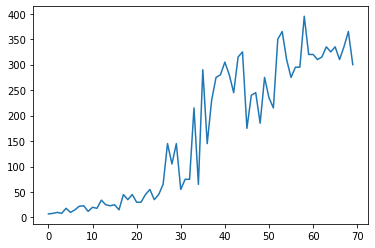

In [153]:
plt.plot(best_scores)
plt.show()

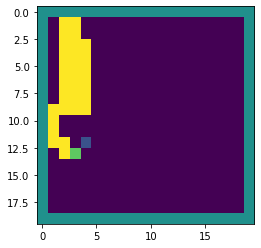

In [154]:
fig = plt.figure()
ims = []
for s in best_gameplays[-1]:
  im = plt.imshow(s, animated=True)
  ims.append([im])
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=0)

rc('animation', html='jshtml')

ani